In [2]:
#############################################
# FEATURE ENGINEERING & DATA PRE-PROCESSING
#############################################

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

#We will work on two different datasets: "titanic.csv" and 
#"application_train.csv" . Titanic is a smaller dataset, 
#and application_train is bigger dataset. In most of cases,
#we will deal with big datasets. So, you will see how the size of data
#affects our results.

(307511, 122)
(891, 12)


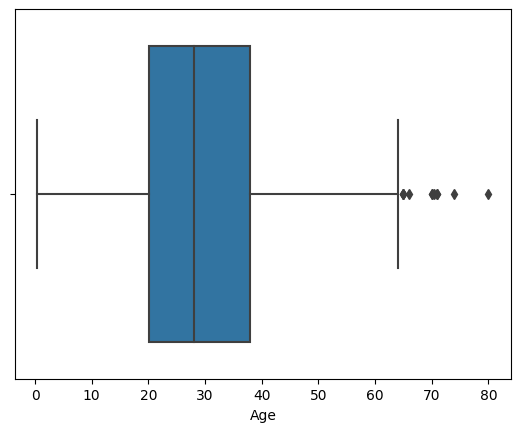

In [3]:
def load_application_train():
    data = pd.read_csv("application_train.csv")
    return data
    
#See the shape of bigger dataset
df = load_application_train()
print(df.shape)        # (307511, 122)



def load():
    data = pd.read_csv("titanic.csv")
    return data

#See the shape of smaller dataset
df = load()
print(df.shape)       # (891, 12)


#Let's begin with the smaller dataset, "titanic.csv"
#We will try to detect outliers in a numerical 'Age' column by using 
#boxplot.

sns.boxplot(x=df["Age"])
plt.show()  #IMAGE IS BELOW ('titan_age_outlier.png')

In [4]:
#We know how a boxplot is constructed. So we need to find Q1(25th percentile)
#Q3(75th percentile), and then minimum and maximum values by using 1.5IQR.

q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr


#Now see outliers
print(df[(df["Age"] < low) | (df["Age"] > up)])

'''
     PassengerId  Survived  Pclass                                  Name   Sex   Age  SibSp  Parch      Ticket     Fare Cabin Embarked
33            34         0       2                 Wheadon, Mr. Edward H  male  66.0      0      0  C.A. 24579  10.5000   NaN        S
54            55         0       1        Ostby, Mr. Engelhart Cornelius  male  65.0      0      1      113509  61.9792   B30        C
96            97         0       1             Goldschmidt, Mr. George B  male  71.0      0      0    PC 17754  34.6542    A5        C
116          117         0       3                  Connors, Mr. Patrick  male  70.5      0      0      370369   7.7500   NaN        Q
280          281         0       3                      Duane, Mr. Frank  male  65.0      0      0      336439   7.7500   NaN        Q
456          457         0       1             Millet, Mr. Francis Davis  male  65.0      0      0       13509  26.5500   E38        S
493          494         0       1               Artagaveytia, Mr. Ramon  male  71.0      0      0    PC 17609  49.5042   NaN        C
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson  male  80.0      0      0       27042  30.0000   A23        S
672          673         0       2           Mitchell, Mr. Henry Michael  male  70.0      0      0  C.A. 24580  10.5000   NaN        S
745          746         0       1          Crosby, Capt. Edward Gifford  male  70.0      1      1   WE/P 5735  71.0000   B22        S
851          852         0       3                   Svensson, Mr. Johan  male  74.0      0      0      347060   7.7750   NaN        S
'''



#Index of outliers
print(df[(df["Age"] < low) | (df["Age"] > up)].index)

#Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

#You can directly check if there is a outlier or not by using any() function.
print(df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None))  #True
#It returns true because there are some rows that lie beyond the
#thresholds we specified. We used a parameter called axis=None since we don't 
#care rows or columns. 

#However, if you remember titan_age_outlier.png, you see that there is no
#outlier that is lower than the threshold. Therefore, the below code will
#return False.
print(df[(df["Age"] < low)].any(axis=None))  #  False

     PassengerId  Survived  Pclass                                  Name   
33            34         0       2                 Wheadon, Mr. Edward H  \
54            55         0       1        Ostby, Mr. Engelhart Cornelius   
96            97         0       1             Goldschmidt, Mr. George B   
116          117         0       3                  Connors, Mr. Patrick   
280          281         0       3                      Duane, Mr. Frank   
456          457         0       1             Millet, Mr. Francis Davis   
493          494         0       1               Artagaveytia, Mr. Ramon   
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   
672          673         0       2           Mitchell, Mr. Henry Michael   
745          746         0       1          Crosby, Capt. Edward Gifford   
851          852         0       3                   Svensson, Mr. Johan   

      Sex   Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   male  66.0    

In [5]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit




print(outlier_thresholds(df, "Age")) # (-6.6875, 64.8125)
#As you can see, if age is below -6.68 or higher 64.81, we can say that
#it is an outlier. But be careful, age cannot be lower than 0. So we don't
#need to care lower threshold since it is -6.68





low, up = outlier_thresholds(df, "Fare")
print(df[(df["Fare"] < low) | (df["Fare"] > up)].head())

'''
    PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch    Ticket      Fare        Cabin Embarked
1             2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0  PC 17599   71.2833          C85        C
27           28         0       1                     Fortune, Mr. Charles Alexander    male  19.0      3      2     19950  263.0000  C23 C25 C27        S
31           32         1       1     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1      0  PC 17569  146.5208          B78        C
34           35         0       1                            Meyer, Mr. Edgar Joseph    male  28.0      1      0  PC 17604   82.1708          NaN        C
52           53         1       1           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1      0  PC 17572   76.7292          D33        C
'''





#Write a function that check if there is any outliers.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

print(check_outlier(df, "Age"))    # True  (yes, there is at least 1 outlier.)
print(check_outlier(df, "Fare"))   # True  (yes, there is at least 1 outlier.)







#We will try to grab categorical columns, categorical but cardinal columns and
#numerical columns. 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    '''
    Returns categorical columns list, numerical columns list and categorical but cardinal column list.

    Parameters
    ----------
    dataframe: dataframe
        main dataframe
    cat_th: int, float
        threshold for the number of unique variable of a column that seems numerical but actually categorical
    car_th: int, float
        threshold for the number of unique variable of a column that seems categorical but actually cardinal
    
    Returns
    -------
    cat_cols: list
        list of categorical columns
    num_cols: list
        list of numerical columns
    cat_but_car: list
        list of of cardinal columns
    
    Notes
    ------
    -> cat_cols + num_cols + cat_but_car = the number of columns of dataframe
    -> cat_cols includes num_but_cat
    -> Categorical variables with numerical appearance are also included in categorical variables.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    '''


    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car




cat_cols, num_cols, cat_but_car = grab_col_names(df)
'''
Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
'''



num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols)  #  ['Age', 'Fare']



#We will check outliers in numerical columns.
for col in num_cols:
    print(col, check_outlier(df, col))
'''
Age True
Fare True
'''

(-6.6875, 64.8125)
    PassengerId  Survived  Pclass   
1             2         1       1  \
27           28         0       1   
31           32         1       1   
34           35         0       1   
52           53         1       1   

                                                 Name     Sex   Age  SibSp   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1  \
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male  28.0      1   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   

    Parch    Ticket      Fare        Cabin Embarked  
1       0  PC 17599   71.2833          C85        C  
27      2     19950  263.0000  C23 C25 C27        S  
31      0  PC 17569  146.5208          B78        C  
34      0  PC 17604   82.1708          NaN        C  
52      0  PC 17572

'\nAge True\nFare True\n'

In [6]:
#Let's import application_train.csv
dff = load_application_train()

cat_cols, num_cols, cat_but_car = grab_col_names(dff)
'''
Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39
'''


#Although 'SK_ID_CURR' is a numerical column, it is irrelevant for us. Therefore,
#we will remove it from num_cols
num_cols.remove('SK_ID_CURR')

print()
print()

#Let's see which numerical columns have outliers.
for col in num_cols:
    print(col, check_outlier(dff, col))

'''
CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
...
Output is truncated.
'''





#The function below will show us the outlier values for the associated column.
#If there are outliers more than 10, it will only show us first 5 (f = 5) outliers.
#Otherwise, it will show all outliers. 

def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index





age_index = grab_outliers(df, "Age", True)
'''
     PassengerId  Survived  Pclass                            Name   Sex   Age  SibSp  Parch      Ticket     Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male  66.0      0      0  C.A. 24579  10.5000   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male  65.0      0      1      113509  61.9792   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male  71.0      0      0    PC 17754  34.6542    A5        C
116          117         0       3            Connors, Mr. Patrick  male  70.5      0      0      370369   7.7500   NaN        Q
280          281         0       3                Duane, Mr. Frank  male  65.0      0      0      336439   7.7500   NaN        Q
'''

#Now see the index of outliers...
print(age_index) # Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE Tru

In [7]:
#Let's import titanic data.
df = load()

###############################################
#Remove Outliers..
###############################################
low, up = outlier_thresholds(df, "Fare")
#Shape of data with outliers
print(df.shape) # (891, 12)


#Be careful! We used tilda (~) in order to see the shape of data without outliers!
#There are 116 outliers for 'Fare' variable, therefore if we only remove Fare outliers,
#our new data will have (775,12) 
print(df[~((df["Fare"] < low) | (df["Fare"] > up))].shape) #(775,12) 

#We can write a function for this!!!
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

cat_cols, num_cols, cat_but_car = grab_col_names(df)
'''
Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
'''
num_cols.remove('PassengerId')

for col in num_cols:
    df = remove_outlier(df,col)


#Now we removed 'Age' outliers and 'Fare' outliers. Age has 10 outliers and Fare has 116 outliers,
#therefore we removed 126 outliers. 
print(df.shape) # (765,12) 


###############################################
#Re-assignment with thresholds..
###############################################
##Now we will assign outliers with thresholds. We can write a function for this
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit




#Import titanic data.
df = load()


cat_cols, num_cols, cat_but_car = grab_col_names(df)
'''
Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
'''
num_cols.remove('PassengerId')





#Let's see which column has outliers...
for col in num_cols:
    print(col, check_outlier(df, col))

'''
Age True
Fare True
'''




#Now replace these outliers with thresholds.
for col in num_cols:
    replace_with_thresholds(df, col)



#After replacing, we shouldn't have any outlier. So let's check again.
for col in num_cols:
    print(col, check_outlier(df, col))

'''
Age False
Fare False
'''

(891, 12)
(775, 12)
Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
(765, 12)
Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True
Age False
Fare False


'\nAge False\nFare False\n'

(53940, 10)
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
(53940, 7)
   carat  depth  table  price     x     y     z
0   0.23   61.5   55.0    326  3.95  3.98  2.43
1   0.21   59.8   61.0    326  3.89  3.84  2.31
2   0.23   56.9   65.0    327  4.05  4.07  2.31
3   0.29   62.4   58.0    334  4.20  4.23  2.63
4   0.31   63.3   58.0    335  4.34  4.35  2.75
carat True
depth True
table True
price True
x True
y True
z True
(1889, 7)
(2545, 7)
[-1.58352526 -1.59732899 -1.62278873 ... -1.06721815 -1.00809552
 -1.00849038]
[-8.60430658 -8.20889984 -5.86084355 -4.98415175 -4.81502092]


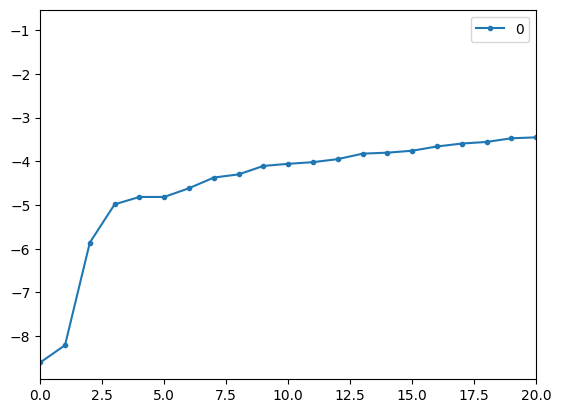

In [8]:
#Let's look at diamonds dataset. There are 53940 rows.
df = sns.load_dataset('diamonds')
print(df.shape)  #  (53940, 10)
print(df.head())

'''
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
'''




#Remove non numeric columns.
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
print(df.shape)   #  (53940, 7)
print(df.head())

'''
   carat  depth  table  price     x     y     z
0   0.23   61.5   55.0    326  3.95  3.98  2.43
1   0.21   59.8   61.0    326  3.89  3.84  2.31
2   0.23   56.9   65.0    327  4.05  4.07  2.31
3   0.29   62.4   58.0    334  4.20  4.23  2.63
4   0.31   63.3   58.0    335  4.34  4.35  2.75
'''




#Let's check columns that contain outliers.
for col in df.columns:
    print(col, check_outlier(df, col))

'''
carat True
depth True
table True
price True
x True
y True
z True
'''




#Let's see how many rows contain outlier 'carat'
low, up = outlier_thresholds(df, "carat")
print(df[((df["carat"] < low) | (df["carat"] > up))].shape)  # (1889, 7)
#As you can see there are so many 'carat' outlier.




#see how many rows contain outlier 'depth'
low, up = outlier_thresholds(df, "depth")
print(df[((df["depth"] < low) | (df["depth"] > up))].shape)  # (2545, 7)
#And there are also many 'depth' outlier.




#Now we will create a Local Outlier Factor with n_neighbors = 20
#Generally, we use n_neighbors = 20
#Then, we will transform each point to a score according to the LOF.
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
print(df_scores)
#[-1.58352526 -1.59732899 -1.62278873 ... -1.06721815 -1.00809552  -1.00849038]
#These points are negative and there are 53940 points. The closer to -1, 
#the higher the chance of not being an outlier.




#Let's sort df_scores and see first 5 of them.
print(np.sort(df_scores)[0:5]) # array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])




#Now see first 20 sorted  df_scores.
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()  #IMAGE IS BELOW! LOF.png

In [9]:
th = np.sort(df_scores)[3] # 4th point is our threshold.
print(th)                  # -4.9841





#Now let's look at the rows that are outliers.
print(df[df_scores < th])
'''
       carat  depth  table  price     x      y      z
41918   1.03   78.2   54.0   1262  5.72   5.59   4.42
48410   0.51   61.8   54.7   1970  5.12   5.15  31.80
49189   0.51   61.8   55.0   2075  5.15  31.80   5.12
'''





#And we drop these above 3 rows from our dataset...
print(df.drop(axis=0, labels=df[df_scores < th].index).shape) #(53937, 7)

-4.984151747711709
       carat  depth  table  price     x      y      z
41918   1.03   78.2   54.0   1262  5.72   5.59   4.42
48410   0.51   61.8   54.7   1970  5.12   5.15  31.80
49189   0.51   61.8   55.0   2075  5.15  31.80   5.12
(53937, 7)
